# Cell clustering notebook

Note: this notebook should be run after `example_pixel_clustering.ipynb`

In [ ]:
# import required packages
from datetime import datetime as dt
import os
import subprocess

import feather
import json
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr

from ark.analysis import visualize
from ark.phenotyping import som_utils
from ark.utils import data_utils, io_utils, load_utils, plot_utils

## 1: Load parameters for cell clustering (computed by pixel_clustering)

The file name should be in the form `{pixel_cluster_prefix}_cell_clustering_params.json`. Make sure to set `base_dir` to the same value used in `example_pixel_clustering.ipynb`.

NOTE: `{pixel_cluster_prefix}` is set in `example_pixel_clustering.ipynb`. If you did not explicity set a `{pixel_cluster_prefix}` in `example_pixel_clustering.ipynb`, the prefix defaults to the timestamp of the run. Please check the run directory (`base_dir` as set in `example_pixel_clustering.ipynb`) to see the prefix that was used.

In [ ]:
# define the base dir
base_dir = "../data/granulomaCohort_allData"

# change the prefix of cell_clustering_params_name accordingly
cell_clustering_params_name = '2021-11-20T00:51:10_cell_clustering_params.json'

The following params are loaded:

* `fovs`: the set of fovs
* `channels`: the subset of markers
* `segmentation_dir`: the path to the directory containing your segmentations (generated from Segment_Image_Data.ipynb). Should be set to the same value as `base_dir` in `example_pixel_clustering.ipynb`
* `pixel_consensus_dir`: the name of the directory containing pixel data with the pixel SOM and consensus cluster assignments
* `pc_chan_avg_cluster_name`: the name of the file containing the average marker channel expression per pixel SOM cluster, used for the visualization of weighted channel average per cell
* `pc_chan_avg_hCluster_cap_name`: the name of the file containing the average marker channel expression per pixel meta cluster, used for the visualization of weighted channel average per cell

Additionally, define the following param:

* `cell_table_name`: name of the cell table created by `Segment_Image_Data.ipynb`, should be placed in the root of `base_dir`. You can use either the normalized or arcsinh versions.

In [ ]:
# load the params
with open(os.path.join(base_dir, cell_clustering_params_name)) as fh:
    cell_clustering_params = json.load(fh)
    
# assign the params to variables
fovs = cell_clustering_params['fovs']
channels = cell_clustering_params['channels']
segmentation_dir = cell_clustering_params['segmentation_dir']
pixel_consensus_dir = cell_clustering_params['pixel_consensus_dir']
pc_chan_avg_som_cluster_name = cell_clustering_params['pc_chan_avg_som_cluster_name']
pc_chan_avg_meta_cluster_name = cell_clustering_params['pc_chan_avg_meta_cluster_name']

# define the cell table name
cell_table_name = 'cell_table_size_normalized.csv'

## 2: Cell clustering

### 2.1: train cell SOM

Set a prefix to be applied to all data directories/files created by pixel and cell clustering. If the prefix is not set, a default of the datetime at the start of the run is used. The following data directories/files will be created for pixel clustering:

* `cell_clustered_name`: file to store cell data with just the SOM cluster assignments
* `cell_consensus_name`: file to store cell data with the SOM and consensus cluster assignments
* `cell_weights_name`: file name to place the cell SOM weights
* `cluster_counts_name`: file name to store the counts of each pixel SOM/meta cluster per cell cluster
* `cluster_counts_norm_name`: same as above, except with each value normalized by the respective cell's size
* `weighted_cell_channel_avg_name`: file name to store the weighted cell channel expression for each cell. Refer to <a href=https://ark-analysis.readthedocs.io/en/latest/_markdown/ark.phenotyping.html#ark.phenotyping.som_utils.compute_p2c_weighted_channel_avg>cell channel weighting docs</a> for how the weighting is computed.
* `cell_clust_to_meta_name`: file name to store the mapping between cell SOM clusters and cell meta clusters
* `cell_som_cluster_avgs_name`: file name to store the average number of cell SOM clusters per cell cluster
* `cell_meta_cluster_avgs_name`: same as above except for cell meta clusters
* `cell_cluster_channel_avg_name`: file name to store the average weighted channel expression across each cell cluster. You will be able to specify which cell cluster (SOM or meta) to use later in the notebook.

Additionally, define the following variable:

* `pixel_cluster_col`: whether to use pixel SOM or meta cluster counts for training/aggregating. Set to `'pixel_som_cluster'` or `'pixel_meta_cluster'` respectively.

In [ ]:
# explicitly set cell_cluster_prefix to override datetime default
cell_cluster_prefix = None

if cell_cluster_prefix is None:
    cell_cluster_prefix = dt.now().strftime('%Y-%m-%dT%H:%M:%S')
    
# define the cell SOM cluster and cell SOM weights paths, explicitly set the variables to use custom names
cell_clustered_name = '%s_cell_mat_clustered.feather' % cell_cluster_prefix
cell_consensus_name = '%s_cell_mat_consensus.feather' % cell_cluster_prefix
cell_weights_name = '%s_cell_weights.feather' % cell_cluster_prefix
cluster_counts_name = '%s_cluster_counts.feather' % cell_cluster_prefix
cluster_counts_norm_name = '%s_cluster_counts_norm.feather' % cell_cluster_prefix
weighted_cell_channel_avg_name = '%s_weighted_cell_channel_avg.csv' % cell_cluster_prefix
cell_clust_to_meta_name = '%s_cell_clust_to_meta.feather' % cell_cluster_prefix
cell_som_cluster_avgs_name = '%s_cell_som_cluster_avgs.csv' % cell_cluster_prefix
cell_meta_cluster_avgs_name ='%s_cell_meta_cluster_avgs.csv' % cell_cluster_prefix
cell_cluster_channel_avg_name = '%s_cell_cluster_channel_avg.csv' % cell_cluster_prefix

# define the type of pixel cluster to aggregate on
pixel_cluster_col = 'pixel_meta_cluster'

Train the cell SOM on the normalized number of pixel SOM/meta clusters per cell (the data stored in `cluster_counts_norm_name`).  Training is done using the `FlowSOM` algorithm. Note that each of the pixel SOM/meta cluster columns are normalized by their 99.9% value prior to training.

Additionally, this function also computes the weighted cell channel table (the data stored in `weighted_cell_channel_avg_name`). This data will be needed to compute the average channel expression per cell cluster (the data stored in `cell_cluster_channel_avg_name`), which will be used when computing weighted channel average per cell cluster later on. See documentation of `compute_p2c_weighted_channel_avg` for how weighted cell channel average is computed: <a href=https://ark-analysis.readthedocs.io/en/latest/_markdown/ark.phenotyping.html#ark.phenotyping.som_utils.compute_p2c_weighted_channel_avg>cell channel weighting docs</a>

For a full set of parameters you can customize for train_cell_som, please consult: <a href=https://ark-analysis.readthedocs.io/en/latest/_markdown/ark.phenotyping.html#ark.phenotyping.som_utils.train_cell_som>cell training docs</a>

In [ ]:
# depending on which pixel_cluster_col is selected, choose the pixel channel average table accordingly
if pixel_cluster_col == 'pixel_som_cluster':
    pc_chan_avg_name = pc_chan_avg_som_cluster_name
elif pixel_cluster_col == 'pixel_meta_cluster':
    pc_chan_avg_name = pc_chan_avg_meta_cluster_name
    
# create the cell-level SOM weights
som_utils.train_cell_som(
    fovs,
    base_dir,
    pixel_consensus_dir=pixel_consensus_dir,
    cell_table_name=cell_table_name,
    cluster_counts_name=cluster_counts_name,
    cluster_counts_norm_name=cluster_counts_norm_name,
    pixel_cluster_col=pixel_cluster_col,
    pc_chan_avg_name=pc_chan_avg_name,
    weights_name=cell_weights_name,
    weighted_cell_channel_avg_name=weighted_cell_channel_avg_name,
    num_passes=10
)

### 2.2: assign cell SOM clusters

Use the weights learned from `train_cell_som` to assign cell clusters to the cell dataset. As with `train_cell_som`, note that this is done on the normalized pixel SOM/meta cluster counts table and each of the columns are normalized by their 99.9% value prior to assigning a cell SOM cluster label.

This function also computes the average number of pixel SOM/meta clusters per cell SOM cluster (z-scored) as well as the number of cells in each cell SOM cluster (the data placed in `cell_som_cluster_avgs_name`). This is needed for consensus clustering.

In [ ]:
# use cell SOM weights to assign cell clusters
som_utils.cluster_cells(
    base_dir,
    cluster_counts_norm_name=cluster_counts_norm_name,
    weights_name=cell_weights_name,
    cell_cluster_name=cell_clustered_name,
    pixel_cluster_col_prefix=pixel_cluster_col,
    cell_som_cluster_avgs_name=cell_som_cluster_avgs_name
)

### 2.5: run cell consensus clustering

With the SOM cluster labels assigned to the cell data, assign consensus cluster labels. The consensus clusters are trained on the average number of pixel SOM/meta clusters across all cell SOM clusters (the data stored in `cell_som_cluster_avgs_name`): z-scored values are capped at the value specified in the `cap` argument prior to training.

After consensus clustering, the following are also computed:

* The average number of pixel SOM/meta clusters across all cell meta clusters (z-scored), and the number of cells per meta cluster (the data placed in `cell_meta_cluster_avgs_name`)
* The meta cluster mapping for each cell SOM cluster in `cell_som_cluster_avgs_name` (data is resaved, same data except with an associated meta cluster column)
* The weighted channel average across all cell clusters (z-scored). You can specify which type of cell cluster (SOM or meta) by setting `cell_cluster_col` accordingly. It should be set to `'cell_som_cluster'` or `'cell_meta_cluster'`

For a full set of parameters you can customize for cell_consensus_cluster, please consult: <a href=https://ark-analysis.readthedocs.io/en/latest/_markdown/ark.phenotyping.html#ark.phenotyping.som_utils.cell_consensus_cluster>cell consensus clustering docs</a>

* `cell_cluster_col`: which type of cell cluster (SOM or meta) to aggregate the weighted channel average across
* `max_k`: the number of consensus clusters desired
* `cap`: the maximum value to clip values at during consensus clustering

In [ ]:
cell_cluster_col = 'cell_meta_cluster'
max_k = 20
cap = 3

# run hierarchical clustering based on cell SOM cluster assignments
som_utils.cell_consensus_cluster(
    fovs=fovs,
    channels=channels,
    base_dir=base_dir,
    pixel_cluster_col=pixel_cluster_col,
    max_k=max_k,
    cap=cap,
    cell_cluster_name=cell_clustered_name,
    cell_som_cluster_avgs_name=cell_som_cluster_avgs_name,
    cell_meta_cluster_avgs_name=cell_meta_cluster_avgs_name,
    cell_cluster_col=cell_cluster_col,
    weighted_cell_channel_avg_name=weighted_cell_channel_avg_name,
    cell_cluster_channel_avg_name=cell_cluster_channel_avg_name,
    clust_to_meta_name=cell_clust_to_meta_name,
    cell_consensus_name=cell_consensus_name,
)

In [ ]:
cell_som_cluster_avgs_and_counts = pd.read_csv(os.path.join(base_dir, cell_som_cluster_avgs_name))
cell_meta_cluster_avgs_and_counts = pd.read_csv(os.path.join(base_dir, cell_meta_cluster_avgs_name))
cell_cluster_channel_avg = pd.read_csv(os.path.join(base_dir, cell_cluster_channel_avg_name))

## 3: visualize results

### 3.1: number of cells per SOM cluster

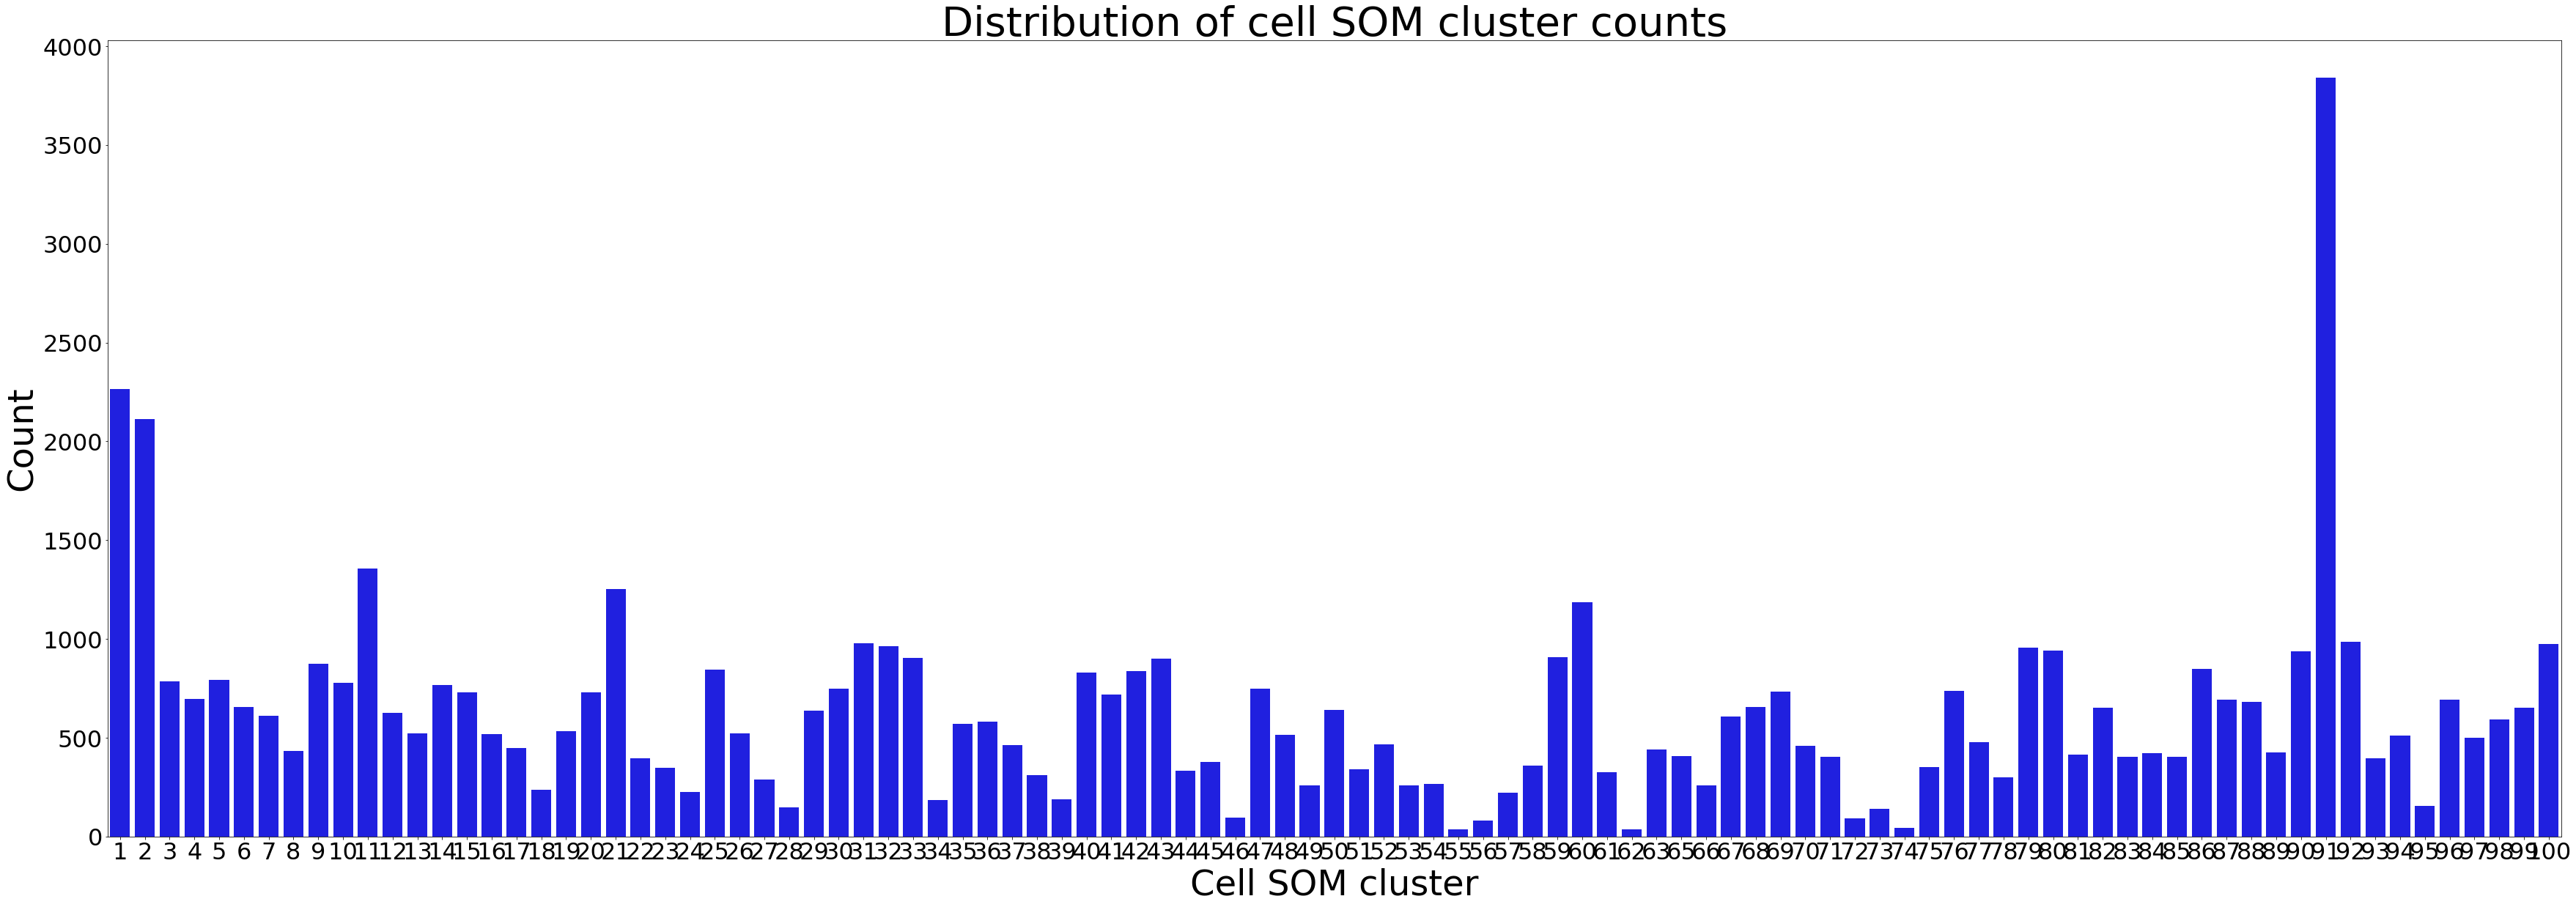

In [9]:
# visualize the cell counts per SOM cluster in a barchart
_ = plt.figure(figsize=(60, 20))
_ = sns.barplot(
    x=cell_som_cluster_avgs_and_counts['cell_som_cluster'],
    y=cell_som_cluster_avgs_and_counts['count'],
    palette=['#0000FF' for i in range(cell_som_cluster_avgs_and_counts.shape[0])]
)
_ = plt.title('Distribution of cell SOM cluster counts', fontsize=56)
_ = plt.xlabel('Cell SOM cluster', fontsize=48)
_ = plt.ylabel('Count', fontsize=48)
_ = plt.xticks(fontsize=32)
_ = plt.yticks(fontsize=32)

### 3.2: average number of pixel clusters per cell SOM cluster (z-scored)

In [ ]:
# define the colormap
meta_cluster_labels = cell_som_cluster_avgs_and_counts['cell_meta_cluster'].unique()
color_palette = sns.color_palette("hls", len(meta_cluster_labels))
colormap = dict(zip(meta_cluster_labels, color_palette))

# map the values, then reindex based on cluster values
som_cluster_index = cell_som_cluster_avgs_and_counts['cell_som_cluster'].values
meta_cluster_mapping = pd.Series(cell_som_cluster_avgs_and_counts['cell_meta_cluster']).map(colormap)
meta_cluster_mapping.index = som_cluster_index

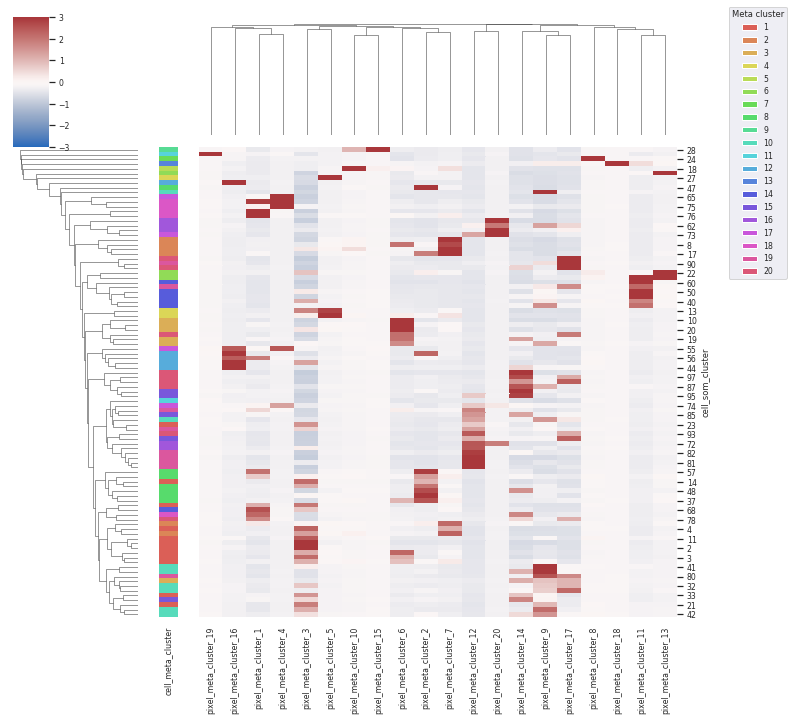

In [11]:
# visualize the average number of pixel clusters per cell SOM cluster (z-scored)
visualize.draw_heatmap(
    data=cell_som_cluster_avgs_and_counts[['pixel_meta_cluster_%d' % i for i in np.arange(1, 21)]].values,
    x_labels=cell_som_cluster_avgs_and_counts['cell_som_cluster'],
    y_labels=['pixel_meta_cluster_%d' % i for i in np.arange(1, 21)],
    center_val=0,
    min_val=-3,
    max_val=3,
    cbar_ticks=np.arange(-3, 4),
    row_colors=meta_cluster_mapping,
    colormap='vlag'
)

# add a legend for hCluster_cap
handles = [patches.Patch(facecolor=colormap[cmap_name]) for cmap_name in colormap]
_ = plt.legend(
    handles,
    colormap,
    title='Meta cluster',
    bbox_to_anchor=(1.1, 1),
    bbox_transform=plt.gcf().transFigure,
    loc='upper right'
)

### 3.3: number of cells per meta cluster

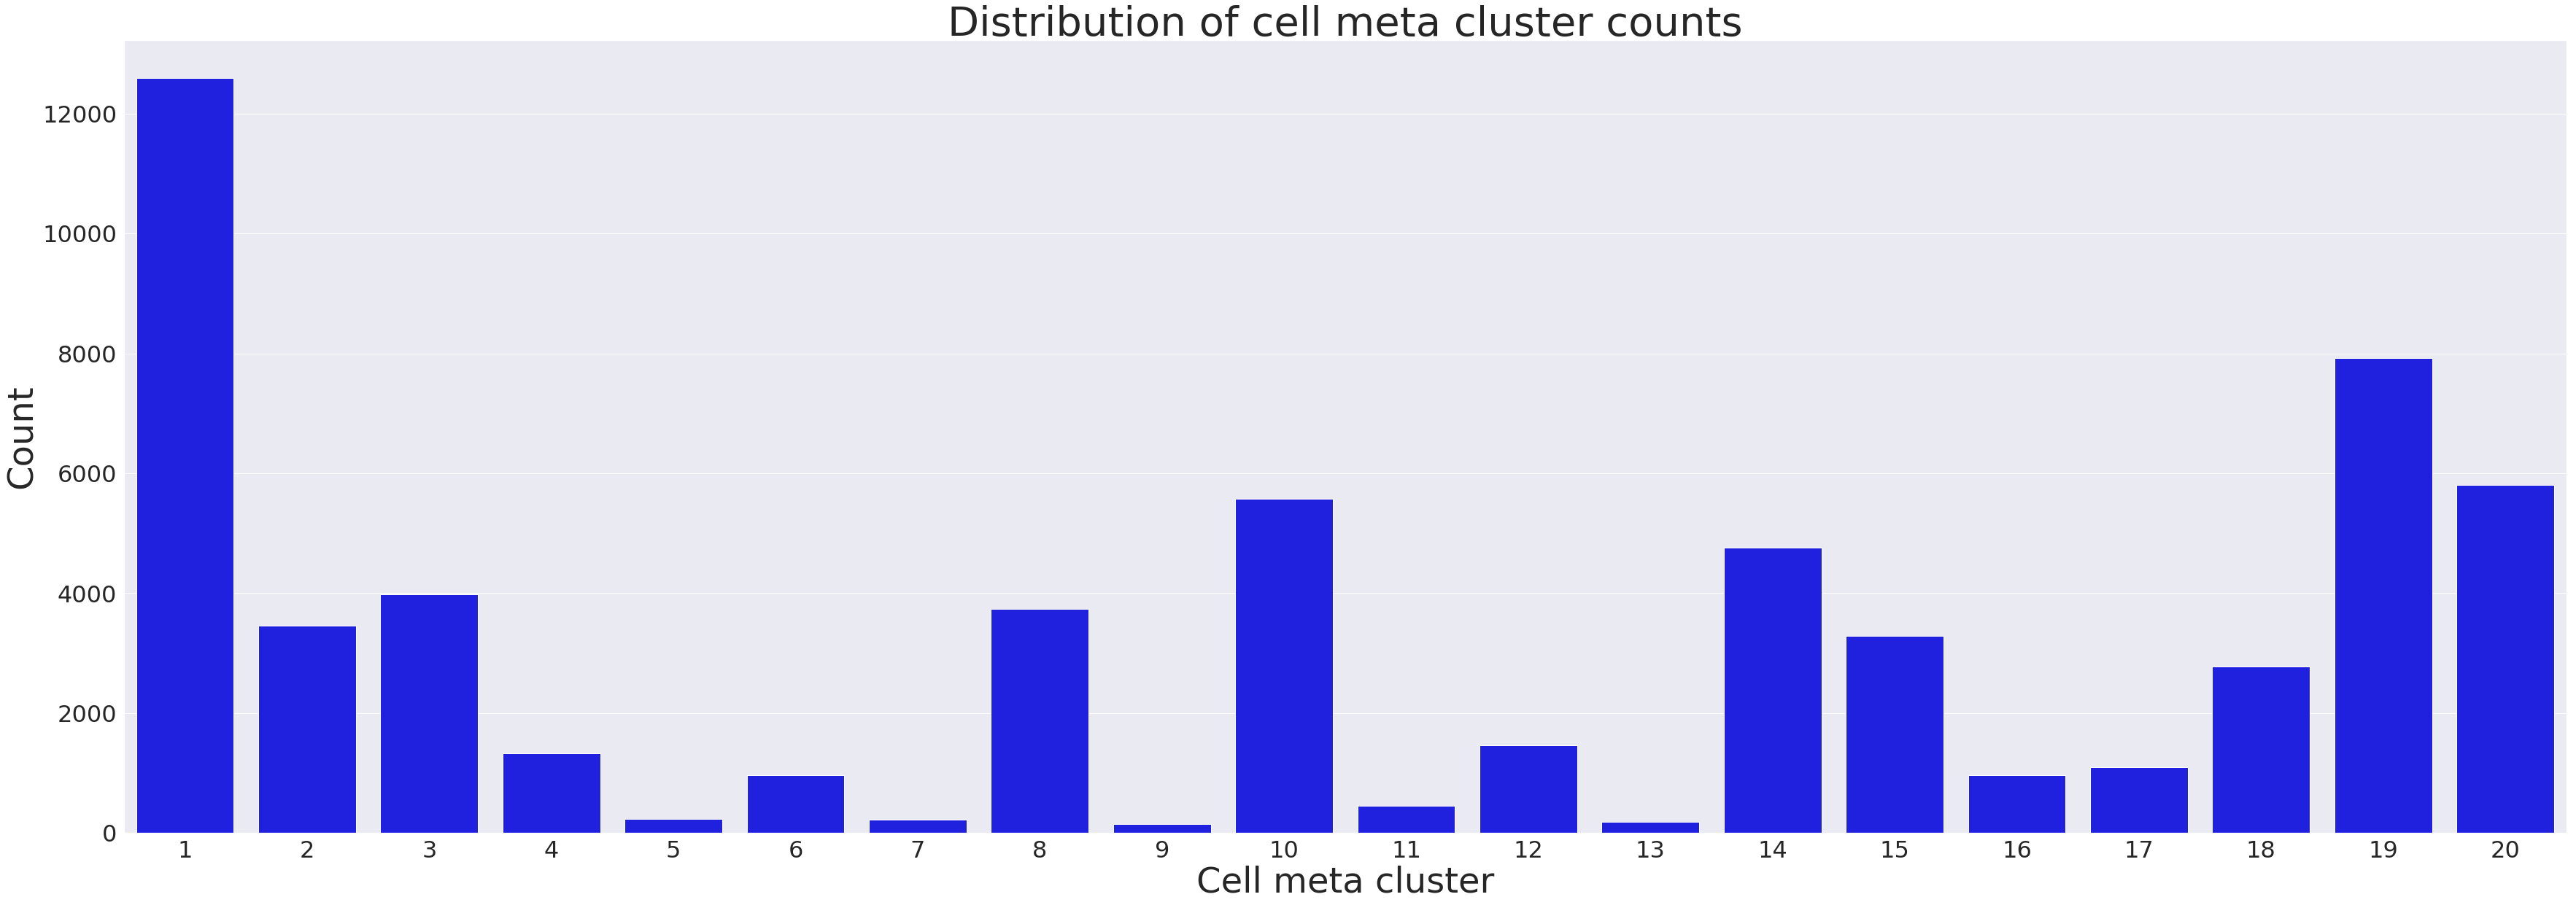

In [12]:
# visualize the cell counts per meta cluster in a barchart
_ = plt.figure(figsize=(60, 20))
_ = sns.barplot(
    x=cell_meta_cluster_avgs_and_counts['cell_meta_cluster'],
    y=cell_meta_cluster_avgs_and_counts['count'],
    palette=['#0000FF' for i in range(cell_meta_cluster_avgs_and_counts.shape[0])]
)
_ = plt.title('Distribution of cell meta cluster counts', fontsize=56)
_ = plt.xlabel('Cell meta cluster', fontsize=48)
_ = plt.ylabel('Count', fontsize=48)
_ = plt.xticks(fontsize=32)
_ = plt.yticks(fontsize=32)

### 3.4: average number of pixel clusters per cell meta cluster (z-scored)

In [ ]:
# define the colormap
meta_cluster_labels = cell_meta_cluster_avgs_and_counts['cell_meta_cluster'].unique()
color_palette = sns.color_palette("hls", len(meta_cluster_labels))
colormap = dict(zip(meta_cluster_labels, color_palette))

# map the values, then reindex based on hCluster_cap values
meta_cluster_index = cell_meta_cluster_avgs_and_counts['cell_meta_cluster'].values
meta_cluster_mapping = pd.Series(cell_meta_cluster_avgs_and_counts['cell_meta_cluster']).map(colormap)
meta_cluster_mapping.index = meta_cluster_index

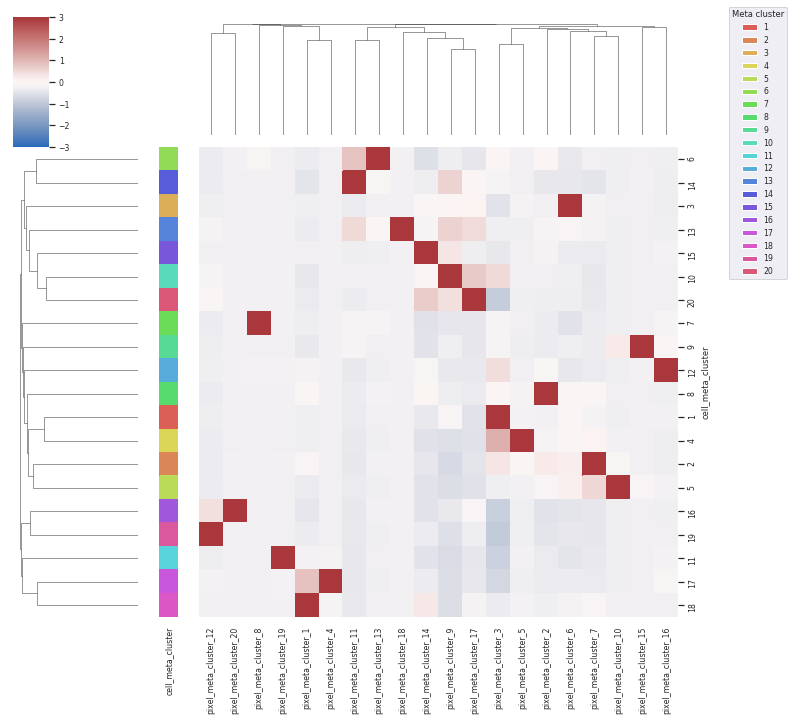

In [14]:
# visualize the average number of pixel clusters per cell SOM cluster (z-scored)
visualize.draw_heatmap(
    data=cell_meta_cluster_avgs_and_counts[['pixel_meta_cluster_%d' % i for i in np.arange(1, 21)]].values,
    x_labels=cell_meta_cluster_avgs_and_counts['cell_meta_cluster'],
    y_labels=['pixel_meta_cluster_%d' % i for i in np.arange(1, 21)],
    center_val=0,
    min_val=-3,
    max_val=3,
    cbar_ticks=np.arange(-3, 4),
    row_colors=meta_cluster_mapping,
    colormap='vlag'
)

# add a legend for hCluster_cap
handles = [patches.Patch(facecolor=colormap[cmap_name]) for cmap_name in colormap]
_ = plt.legend(
    handles,
    colormap,
    title='Meta cluster',
    bbox_to_anchor=(1.1, 1),
    bbox_transform=plt.gcf().transFigure,
    loc='upper right'
)

### 3.5: weighted cell cluster average heatmap over channels (z-scored)

* See documentation of `compute_p2c_weighted_channel_avg` for how weighted cell channel average is computed: <a href=https://ark-analysis.readthedocs.io/en/latest/_markdown/ark.phenotyping.html#ark.phenotyping.som_utils.compute_p2c_weighted_channel_avg>cell channel weighting docs</a>

In [ ]:
# define the colormap
meta_cluster_labels = cell_cluster_channel_avg['cell_meta_cluster'].unique()
color_palette = sns.color_palette("hls", len(meta_cluster_labels))
colormap = dict(zip(meta_cluster_labels, color_palette))

# map the values, then reindex based on hCluster_cap values
meta_cluster_index = cell_cluster_channel_avg[cell_cluster_col].values
meta_cluster_mapping = pd.Series(cell_cluster_channel_avg['cell_meta_cluster']).map(colormap)
meta_cluster_mapping.index = meta_cluster_index

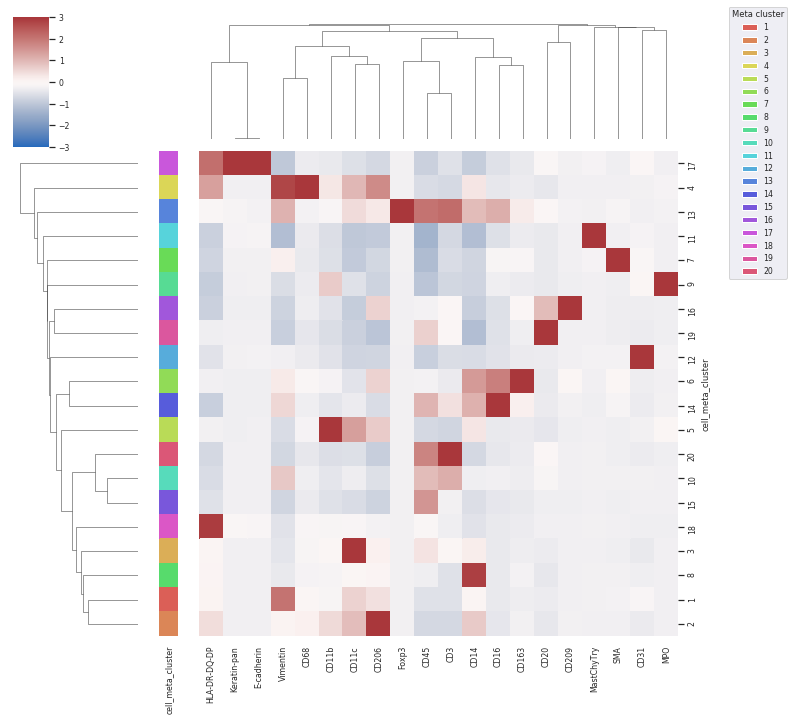

In [16]:
# visualize the cell meta cluster weighted average heatmap over channels (z-scored)
# using weighted average discretizes values better since we take advantage of pixel cluster info
drop_cols = ['cell_meta_cluster'] if cell_cluster_col == 'cell_meta_cluster' else ['cell_som_cluster', 'cell_meta_cluster']
visualize.draw_heatmap(
    data=cell_cluster_channel_avg.drop(columns=drop_cols).values,
    x_labels=cell_cluster_channel_avg[cell_cluster_col],
    y_labels=cell_cluster_channel_avg.drop(columns=drop_cols).columns.values,
    center_val=0,
    min_val=-3,
    max_val=3,
    cbar_ticks=np.arange(-3, 4),
    row_colors=meta_cluster_mapping,
    colormap='vlag'
)

# add a legend for hCluster_cap
handles = [patches.Patch(facecolor=colormap[cmap_name]) for cmap_name in colormap]
_ = plt.legend(
    handles,
    colormap,
    title='Meta cluster',
    bbox_to_anchor=(1.1, 1),
    bbox_transform=plt.gcf().transFigure,
    loc='upper right'
)

### 3.6: cell cluster overlay

In [ ]:
# select fovs to display
cell_fovs = ['fov6', 'fov7']

Note: set `cell_cluster_col` param to `'cell_som_cluster'` if you want to overlay SOM clusters instead

In [ ]:
# generate the cell cluster masks for each fov in cell_fovs
cell_cluster_masks = data_utils.generate_cell_cluster_mask(
    cell_fovs,
    base_dir,
    segmentation_dir,
    cell_consensus_name=cell_consensus_name,
    cell_cluster_col='cell_meta_cluster'
)

* `save_pixel_masks`: replace with True if you want to save, files will be written as `{fov_name}_cell_mask.tiff` in `base_dir`

In [ ]:
save_cell_masks = False

if save_cell_masks:
    data_utils.save_fov_images(
        cell_fovs,
        base_dir,
        cell_cluster_masks,
        name_suffix='_cell_mask'
    )

Note: change `'cell_meta_cluster'` to `'cell_som_cluster'` if you want to overlay SOM clusters instead

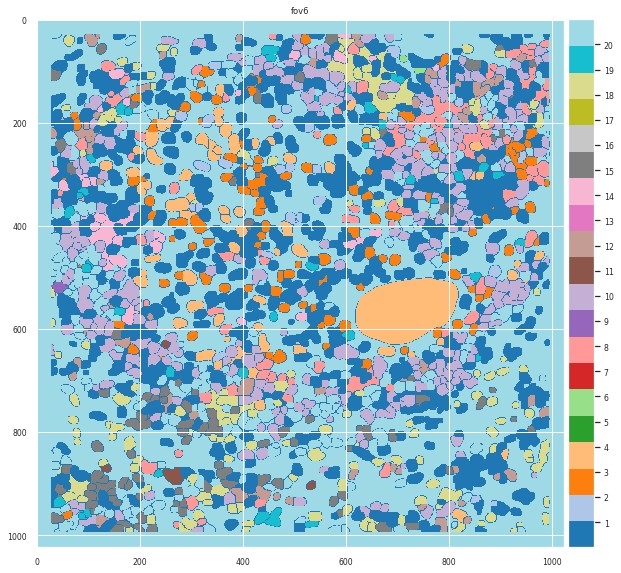

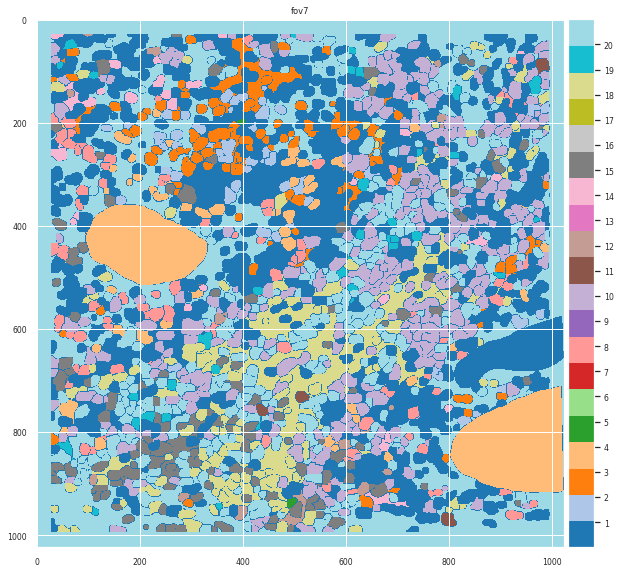

In [20]:
plot_utils.plot_clustering_result(
    cell_cluster_masks,
    cell_fovs,
    tick_range=np.arange(len(cell_som_cluster_avgs_and_counts['cell_meta_cluster'].unique())) + 1
)